In [83]:
import os
import cv2
import random
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [35]:
# Define paths
base_path = "/content/drive/MyDrive/Eye-Mov/datav3"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")

In [37]:
# Ensure sorted and consistent category order
categories = sorted([folder for folder in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, folder))])
print(f"Sorted Categories: {categories}")

Sorted Categories: ['center', 'left', 'right']


## 🖼️ Visualizing Dataset Samples

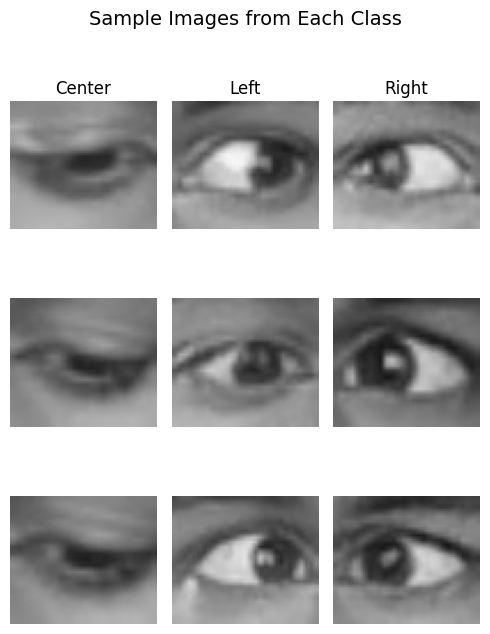

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(5, 7))

for i, category in enumerate(categories):
    image_files = random.sample(os.listdir(os.path.join(train_path, category)), 3)

    for j, img_file in enumerate(image_files):
        img = cv2.imread(os.path.join(train_path, category, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = axes[j, i]
        ax.imshow(img)
        ax.axis("off")

        if j == 0:
            ax.set_title(category.capitalize(), fontsize=12, pad=5)

plt.suptitle("Sample Images from Each Class", fontsize=14)
plt.tight_layout()
plt.show()

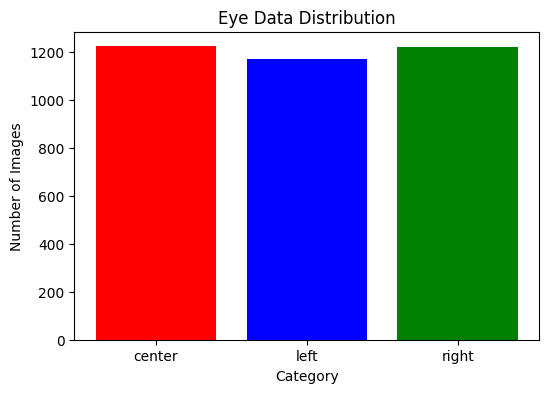

In [43]:
data_distribution = {category: len(os.listdir(os.path.join(train_path, category))) for category in categories}

plt.figure(figsize=(6,4))
plt.bar(data_distribution.keys(), data_distribution.values(), color=["red", "blue", "green"])
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.title("Eye Data Distribution")
plt.show()

In [48]:
unique_shapes = set()

for category in categories:
  cat_path = os.path.join(train_path, category)
  for file in os.listdir(cat_path):
    img = cv2.imread(os.path.join(cat_path, file))
    if img is not None:
      unique_shapes.add(img.shape[:2])

print(f"Unique image shapes in dataset: {unique_shapes}")

Unique image shapes in dataset: {(56, 64)}


In [49]:
sample_img_path = os.path.join(train_path, categories[0], os.listdir(os.path.join(train_path, categories[0]))[0])
img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
image_shape = img.shape + (1,)
print(f"Image Shape: {image_shape}")

Image Shape: (56, 64, 1)


## ➕ Augmentation data train

In [45]:
datrain_gen=ImageDataGenerator(
                             rotation_range=10,
                             rescale=1/255.,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             fill_mode="nearest"
                              )

datest_gen=ImageDataGenerator(
                             rescale=1./255)

In [46]:
datrain_gen.flow_from_directory(train_path)

Found 3622 images belonging to 3 classes.


## 📦 Create Data Generators

In [50]:
train_generator = datrain_gen.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode="grayscale",
    class_mode="categorical",
    classes=categories,
    shuffle=True,
    batch_size=32
)

Found 3622 images belonging to 3 classes.


In [51]:
test_generator = datest_gen.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode="grayscale",
    class_mode="categorical",
    classes=categories,
    shuffle=False,
    batch_size=32
)

Found 831 images belonging to 3 classes.


In [52]:
print(f"Class Indices: {train_generator.class_indices}")

Class Indices: {'center': 0, 'left': 1, 'right': 2}


## 🧠 Define CNN Model

In [59]:
model = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3,3), padding="same", activation="relu", input_shape=image_shape),
    MaxPooling2D((2,2)),

    # Second Convolutional Layer
    Conv2D(64, (3,3), padding="same", activation="relu"),
    MaxPooling2D((2,2)),

    # Third Convolutional Layer
    Conv2D(128, (3,3), padding="same", activation="relu"),
    MaxPooling2D((2,2)),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    # Output Layer
    Dense(len(categories), activation="softmax")
])

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 56, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 28, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 7168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     3,670,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,764,739 (14.36 MB)

 Trainable params: 3,764,739 (14.36 MB)

 Non-trainable params: 0 (0.00 B)

## 🏋️ Train the Model

In [60]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [62]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - accuracy: 0.6497 - loss: 0.7297 - val_accuracy: 0.9687 - val_loss: 0.0580
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.9656 - loss: 0.0887 - val_accuracy: 0.9964 - val_loss: 0.0153
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.9858 - loss: 0.0395 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9857 - loss: 0.0378 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9907 - loss: 0.0243 - val_accuracy: 1.0000 - val_loss: 7.6426e-04
Epoch 6/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.9944 - loss: 0.0174 - val_accuracy: 1.0000 - val_loss: 4.1896e-04
Epoch 7/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.9955 - loss: 0.0119 - val_accuracy: 1.0000 - val_loss: 5.6349e-04
Epoch 8/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.99

## 📈📉 Model Evaluation and Visualization

In [63]:
losses = pd.DataFrame(model.history.history)

<Axes: title={'center': 'Training & Validation Loss'}>

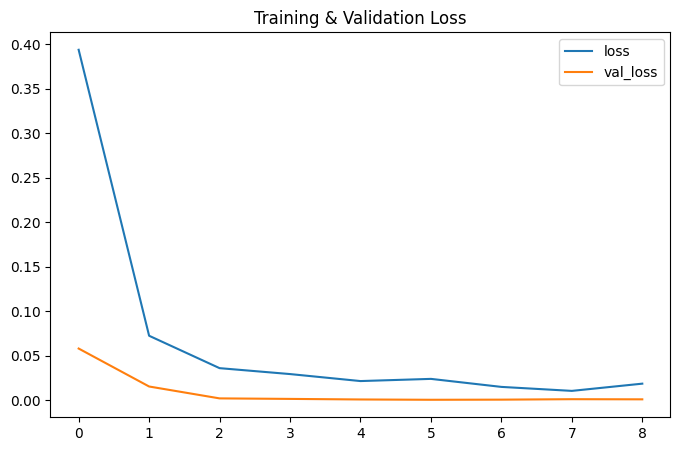

In [64]:
losses[['loss', 'val_loss']].plot(title="Training & Validation Loss", figsize=(8, 5))

<Axes: title={'center': 'Training & Validation Accuracy'}>

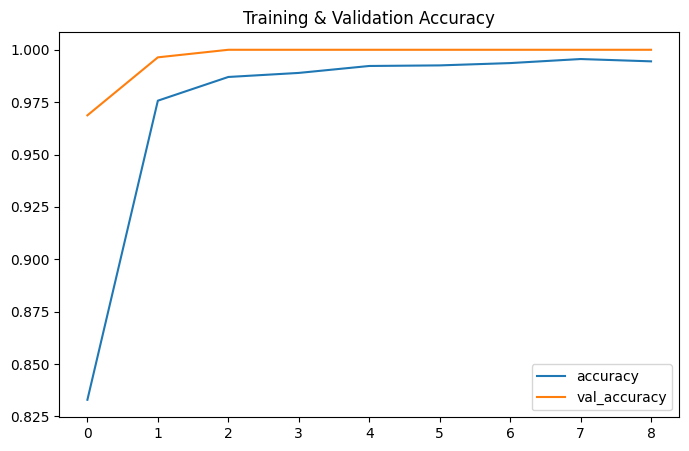

In [65]:
losses[['accuracy', 'val_accuracy']].plot(title="Training & Validation Accuracy", figsize=(8, 5))

In [66]:
X_test, y_test = next(test_generator)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 5.0423e-05
Test Accuracy: 1.0000
Test Loss: 0.0001


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step


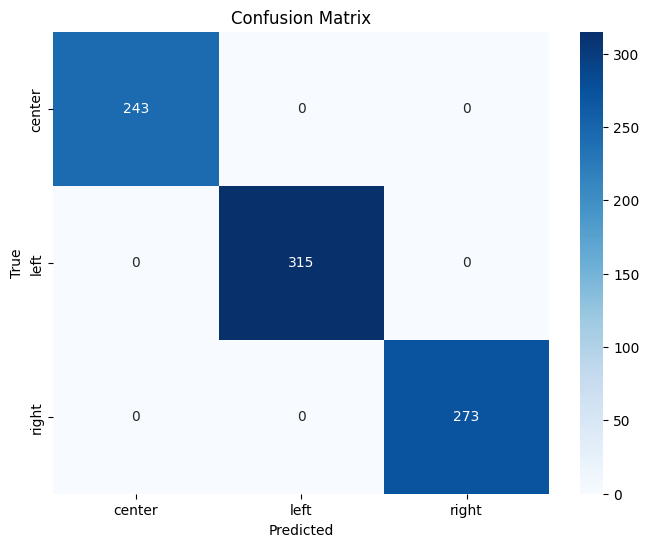

In [76]:
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)
categories = ['center', 'left', 'right']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 📥 Save and Load Model

In [68]:
model.save("eye_modelv4.h5")

In [125]:
model = load_model("/content/eye_modelv4.h5")

## 🔮 Prediction Demo

#### Chcek Preprocessing Data

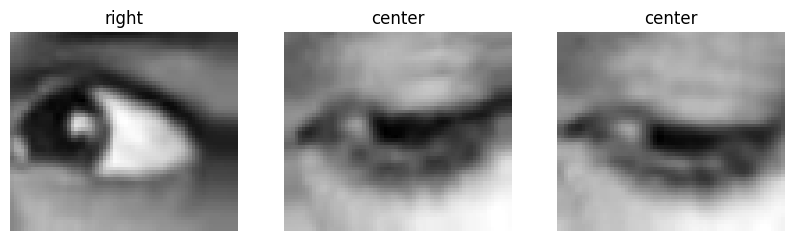

In [105]:
plt.figure(figsize=(10,5))
for i in range(3):
    img, label = next(train_generator)
    plt.subplot(1,3,i+1)
    plt.imshow(img[0].squeeze(), cmap='gray')
    plt.title(categories[np.argmax(label[0])])
    plt.axis('off')
plt.show()

#### Validation with Data Training

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


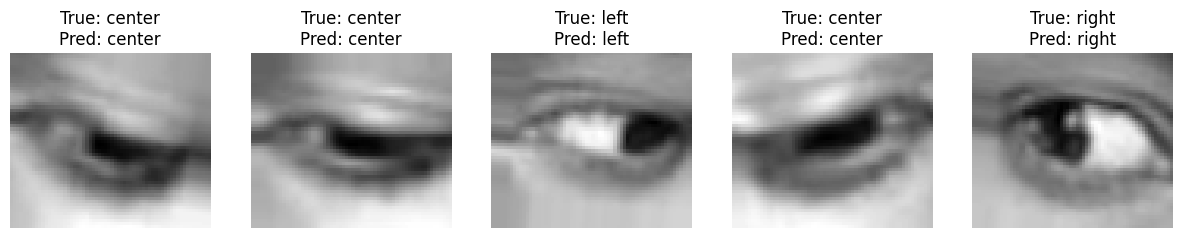

In [107]:
train_img, train_label = next(train_generator)
pred = model.predict(train_img[:5])

# Tampilkan gambar dan hasil prediksi
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(train_img[i].squeeze(), cmap='gray')
    plt.title(f"True: {categories[np.argmax(train_label[i])]}\nPred: {categories[np.argmax(pred[i])]}")
    plt.axis('off')
plt.show()


#### Validation with Data Test

In [114]:
test_generator = datest_gen.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode="grayscale",
    class_mode="categorical",
    classes=categories,
    shuffle=True,
    batch_size=32
)

Found 831 images belonging to 3 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


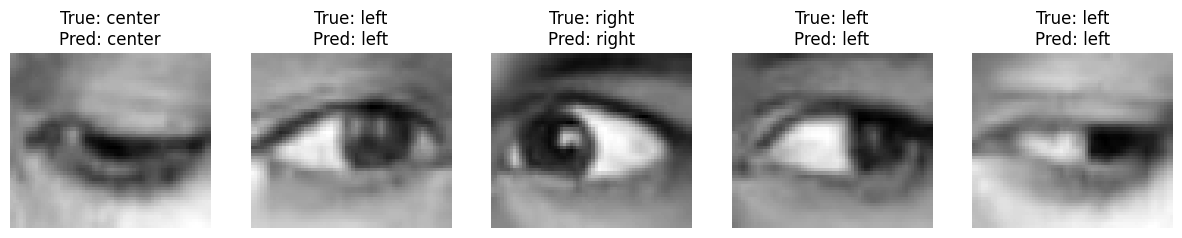

In [115]:
test_img, test_label = next(test_generator)
pred = model.predict(test_img[:5])

plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(test_img[i].squeeze(), cmap='gray')
    plt.title(f"True: {categories[np.argmax(test_label[i])]}\nPred: {categories[np.argmax(pred[i])]}")
    plt.axis('off')
plt.show()

#### 🧪 Alternatif

In [129]:
def predict_custom_image(img_path, model, categories, target_size=(56, 64)):
    img = image.load_img(img_path, color_mode='grayscale', target_size=target_size)

    img_array = image.img_to_array(img)

    img_array = img_array / 255.0

    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    pred_label = categories[np.argmax(prediction)]

    plt.imshow(img_array[0, :, :, 0], cmap='gray')
    plt.title(f"Prediction: {pred_label}")
    plt.axis('off')
    plt.show()

    return pred_label

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


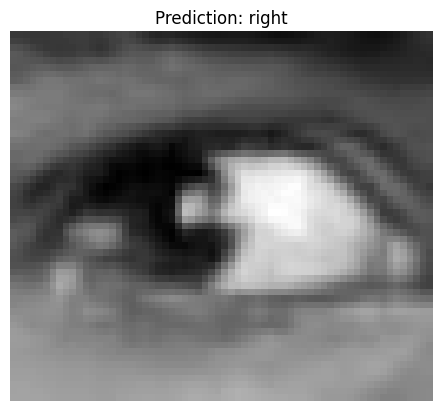

'right'

In [130]:
predict_custom_image("/content/10.jpg", model, categories)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


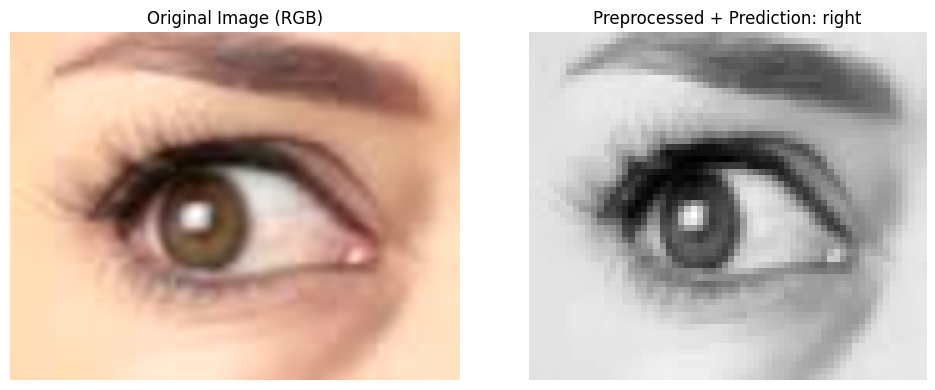

'right'

In [134]:
def predict_custom_image(img_path, model, categories, target_size=(56, 64)):
    original_img = image.load_img(img_path)  # no grayscale
    original_array = image.img_to_array(original_img) / 255.0  # normalize for better display

    img = image.load_img(img_path, color_mode='grayscale', target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array_expanded)
    pred_label = categories[np.argmax(prediction)]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Left: Original image (RGB)
    axes[0].imshow(original_array.astype(np.float32))
    axes[0].set_title("Original Image (RGB)")
    axes[0].axis('off')

    # Right: Grayscale preprocessed image + prediction
    axes[1].imshow(img_array.squeeze(), cmap='gray')
    axes[1].set_title(f"Preprocessed + Prediction: {pred_label}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    return pred_label


predict_custom_image("/content/eye_right.png", model, categories)